# Utilizing Expert Knowledge

## Introduction

1. **Why Utilize Expert Knowledge?**
   - **Data Limitations**: Machine learning models heavily rely on the data they are trained on. However, in scenarios with **small training datasets**, models may struggle to generalize effectively.
   - **Imbalanced Data**: When certain classes or features are underrepresented, models may perform poorly on those cases.
   - **Domain Expertise**: Experts in a specific field often possess valuable insights and domain-specific knowledge that can improve model predictions.

2. **Methods for Incorporating Expert Knowledge:**
   - **Hybrid Models**: Combine machine learning techniques with expert knowledge.
   - **Attention Mechanisms**: Infuse expert knowledge into neural networks using attention mechanisms.
   - **Feature Engineering**: Create new features based on expert insights.
   - **Prior Information**: Use prior knowledge to guide model training.

3. **Examples of Utilizing Expert Knowledge**:
   - **User Modeling**: In educational systems, combining deep neural networks (such as LSTM and CNN) with expert knowledge improves knowledge tracing and personalization.
   - **Quality Prediction in Manufacturing**: Integrating shape expert knowledge into quality prediction models using machine learning methods.
   - **Time-Series Representation Learning**: Incorporating expert features to enhance contrastive learning for time-series representations.

4. **Practical Steps**:
   - **Collaborate**: Engage domain experts to provide insights.
   - **Feature Selection**: Identify relevant features based on expert guidance.
   - **Model Design**: Combine expert knowledge with machine learning architectures.

## Code Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import mglearn

In [2]:
citibike = mglearn.datasets.load_citibike()
print("Citi Bike data:\n{}".format(citibike.head()))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


Text(0, 0.5, 'Rentals')

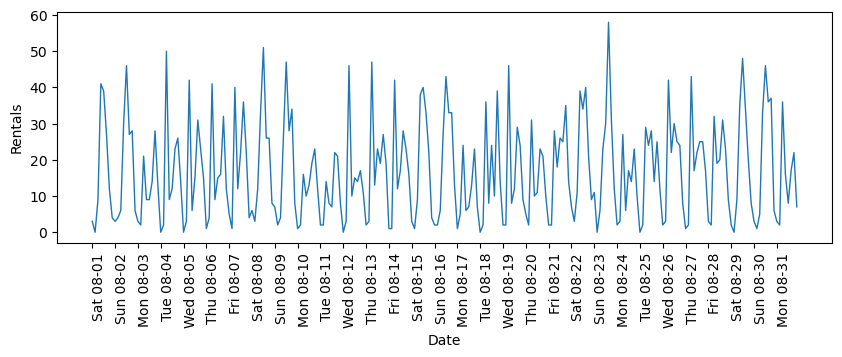

In [3]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

In [5]:
# extract the target values (number of rentals)
y = citibike.values
# convert the time to POSIX time using "%s"
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [6]:
# use the first 184 data points for training, the rest for testing
n_train = 184

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Test-set R^2: -0.04


<Figure size 640x480 with 0 Axes>

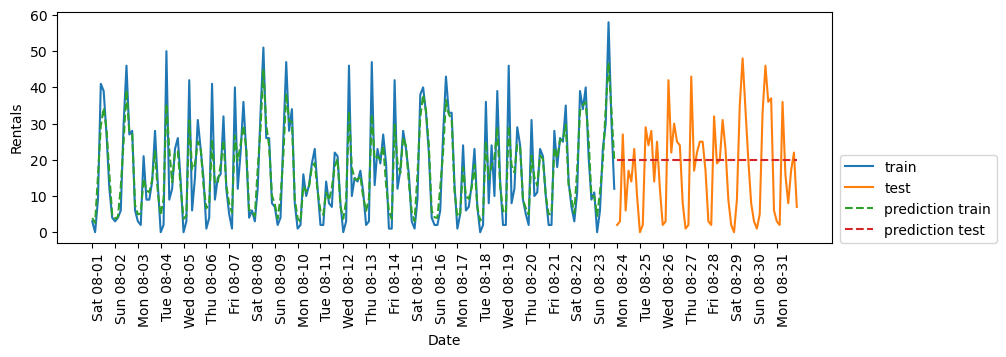

In [7]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
eval_on_features(X, y, regressor)

- The model learned nothing from the POSIX time.
    - The value of the POSIX time feature for the test set is outside of the range of the POSIX time feature for the training set.
    - -> Trees cannot extrapolate.

- Expert Knowledge:
    - the time of day (daytime, evening, night)
    - the day of the week (weekday, weekend)
    - Drop the POSIX time feature.


Test-set R^2: 0.60


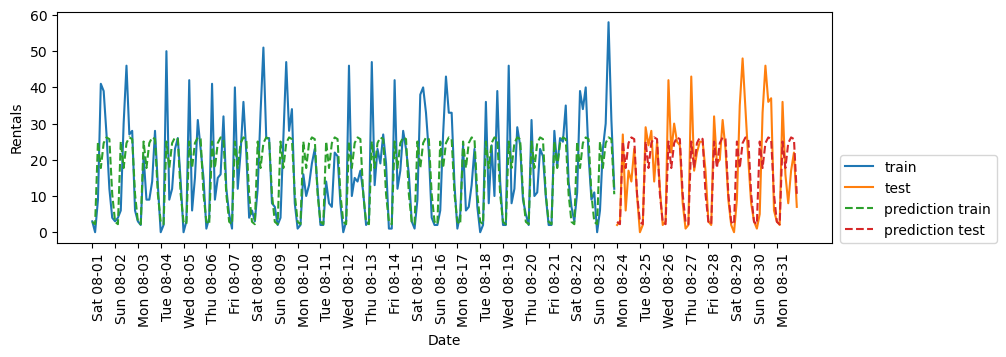

In [8]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

Test-set R^2: 0.84


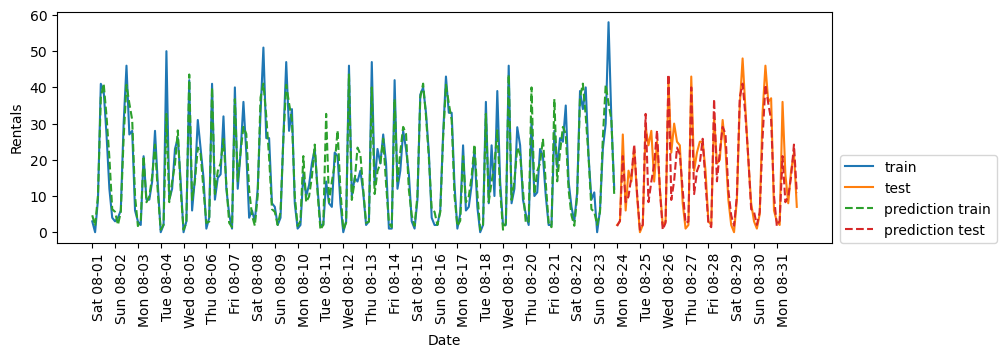

In [9]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1), citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

Test-set R^2: 0.13


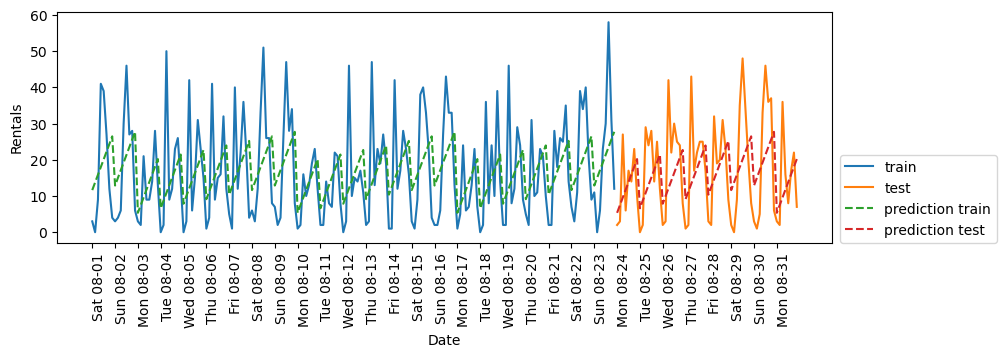

In [10]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

- Linear model works worse:
    - The day of week and time of day encoded as continuous variables.
    - -> It learned that the later in the day, the higher the target value.
    - However, the pattern is more complex.

- Expert Knowledge:
    - Interpret the day of the week and time of day as categorical variables.

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

Test-set R^2: 0.62


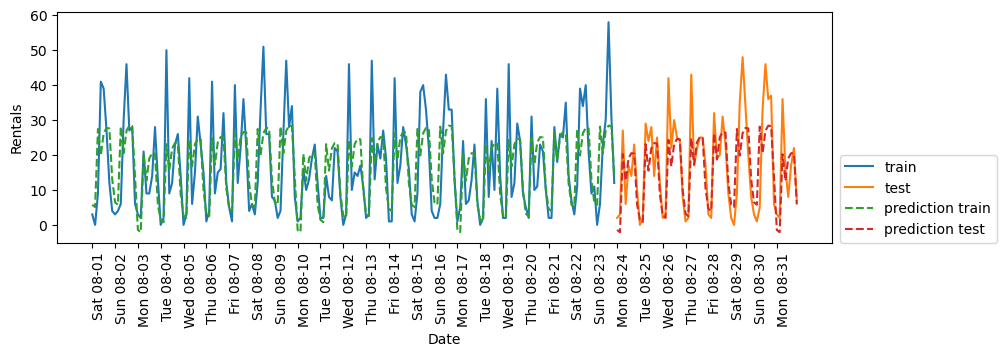

In [14]:
eval_on_features(X_hour_week_onehot, y, Ridge())

- The linear model learns one coefficient for each category.
    - -> That means that the "time of day" pattern is shared over all days of the week.

- Expert Knowledge:
    - Create interaction features between the day of the week and the time of day.
    - -> The model can learn one coefficient for each combination of day of the week and time of day.

Test-set R^2: 0.85


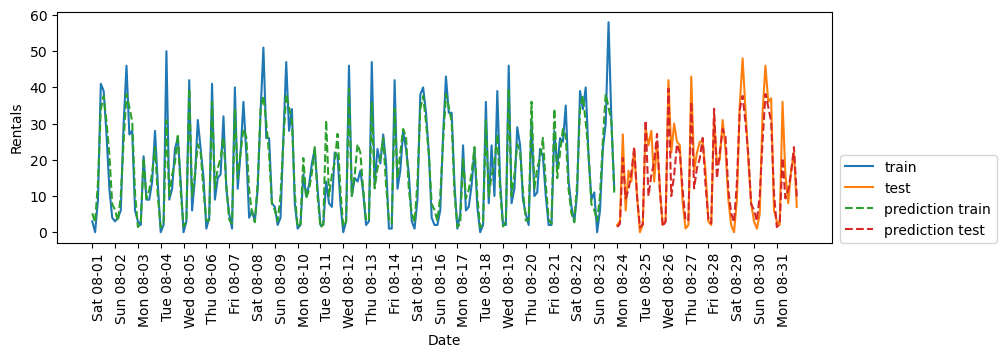

In [15]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [17]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour

features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

Text(0, 0.5, 'Feature magnitude')

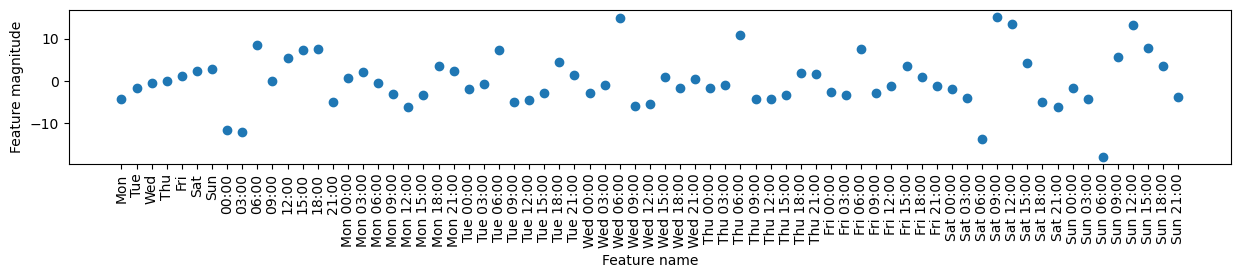

In [18]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")